# **Predicción del Movimiento de Nubes para la Optimización de Plantas Fotovoltaicas en Colombia**

## 1) Descarga de imágenes

A continuación se muestra el código empleado para la descarga de imágenes correspondientes a la banda 13 para el periodo de tiempo comprendido entre el 01/01/2024 y el 31/12/2024. Ingresar al siguiente repositorio de github: https://github.com/alwos19/monografia_esp_cd

## 2) Obtención del dataset

A partir de las imagenes obtenidas se realiza la construcción de una dataset en el que las columnas correspondan a cada hora del día y las filas a cada día del año, dentro de cada celda se ubica la imagen correspondiente con una tamaño de 920X920, el valor de cada pixel corresponde a los valores de radiancia para le día y la hora correspondientes.

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from concurrent.futures import ProcessPoolExecutor

# Ruta donde están almacenados los archivos .npy
ruta_archivos = "./rad13"  # Cambia esto por la ruta real

# Función para procesar un archivo individual
def procesar_archivo(archivo):
    if archivo.endswith(".npy") and archivo.startswith("RadFC_"):
        # Extraer la parte de fecha y hora del nombre del archivo
        try:
            nombre = archivo.replace("RadFC_", "").replace("_Rad13.npy", "")
            fecha_str = nombre[:12]  # 'YYYYMMDDHHMM'
            fecha_datetime = datetime.strptime(fecha_str, "%Y%m%d%H%M")
            
            # Separar fecha y hora
            fecha = fecha_datetime.date()  # Año, mes y día
            hora = fecha_datetime.strftime("%H:%M")  # Solo la hora

            # Cargar los valores de radiancia
            ruta_completa = os.path.join(ruta_archivos, archivo)
            radiancia = np.load(ruta_completa)

            # Validar que la dimensión sea 920 x 920
            if radiancia.shape == (920, 920):
                return {
                    "fecha": fecha,
                    "hora": hora,
                    "radiancia": radiancia
                }
            else:
                print(f"Dimensiones incorrectas en: {archivo}")
        except ValueError:
            print(f"Formato de fecha inválido en: {archivo}")
    return None

# Procesar archivos en paralelo
def procesar_archivos_en_paralelo(ruta_archivos):
    archivos = os.listdir(ruta_archivos)
    datos = []
    with ProcessPoolExecutor() as executor:
        resultados = executor.map(procesar_archivo, archivos)
        for resultado in resultados:
            if resultado is not None:
                datos.append(resultado)
    return datos

# Ejecutar el procesamiento
datos = procesar_archivos_en_paralelo(ruta_archivos)

# Crear el DataFrame
df_imagenes = pd.DataFrame(datos)
df_imagenes["fecha"] = pd.to_datetime(df_imagenes["fecha"])
df_imagenes = df_imagenes.sort_values(by=["fecha", "hora"])

# Mostrar primeras filas
print(df_imagenes.head())

          fecha   hora                                          radiancia
1206 2024-01-01  00:00  [[97.861824, 97.67891, 97.22162, 97.084435, 97...
6522 2024-01-01  01:00  [[94.24924, 98.776405, 99.27942, 99.23369, 99....
2186 2024-01-01  02:00  [[98.684944, 98.82213, 98.684944, 98.86786, 98...
1773 2024-01-01  03:00  [[97.99901, 98.41057, 98.684944, 98.776405, 98...
5567 2024-01-01  04:00  [[99.096504, 98.95932, 98.684944, 98.59348, 98...


In [2]:
df_imagenes.head(2)

,fecha,hora,radiancia
1206,2024-01-01,00:00,"[[97.861824, 97.67891, 97.22162, 97.084435, 97..."
6522,2024-01-01,01:00,"[[94.24924, 98.776405, 99.27942, 99.23369, 99...."


In [3]:
# Crear la columna 'mes'
df_imagenes['mes'] = df_imagenes['fecha'].dt.month

# Reordenar columnas para que 'month' quede después de 'fecha'
cols = list(df_imagenes.columns)
fecha_index = cols.index('fecha')
# Insertamos 'mes' después de 'fecha' y eliminamos su posición anterior
cols.insert(fecha_index + 1, cols.pop(cols.index('mes')))
df_imagenes = df_imagenes[cols]

In [4]:
df_imagenes

,fecha,mes,hora,radiancia
1206,2024-01-01,1,00:00,"[[97.861824, 97.67891, 97.22162, 97.084435, 97..."
6522,2024-01-01,1,01:00,"[[94.24924, 98.776405, 99.27942, 99.23369, 99...."
2186,2024-01-01,1,02:00,"[[98.684944, 98.82213, 98.684944, 98.86786, 98..."
1773,2024-01-01,1,03:00,"[[97.99901, 98.41057, 98.684944, 98.776405, 98..."
5567,2024-01-01,1,04:00,"[[99.096504, 98.95932, 98.684944, 98.59348, 98..."
...,...,...,...,...
8606,2024-12-31,12,19:00,"[[64.34253, 62.239, 64.66263, 60.04401, 55.059..."
6891,2024-12-31,12,20:00,"[[34.618732, 34.390087, 33.566967, 31.966455, ..."
4807,2024-12-31,12,21:00,"[[56.660072, 58.123398, 60.364113, 55.151016, ..."
2089,2024-12-31,12,22:00,"[[87.527084, 86.429596, 83.457214, 81.76524, 8..."


Mirar las graficas del promedio por mes 

In [5]:
df_imagenes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8744 entries, 1206 to 6474
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   fecha      8744 non-null   datetime64[ns]
 1   mes        8744 non-null   int32         
 2   hora       8744 non-null   object        
 3   radiancia  8744 non-null   object        
dtypes: datetime64[ns](1), int32(1), object(2)
memory usage: 307.4+ KB


In [6]:
import pandas as pd
import numpy as np

# Supongamos que ya tienes un DataFrame llamado df

# Función para detectar outliers en una imagen 2D
def detectar_outliers_imagen(imagen):
    imagen_flat = np.array(imagen).flatten()  # Convertimos la imagen en un vector
    q1 = np.percentile(imagen_flat, 25)
    q3 = np.percentile(imagen_flat, 75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    # Máscara de outliers
    outliers_mask = (imagen_flat < lower) | (imagen_flat > upper)
    num_outliers = np.sum(outliers_mask)
    return num_outliers, outliers_mask.reshape((920, 920))

# Aplicamos la función por fila
df_imagenes[['num_outliers', 'outliers_mask']] = df_imagenes['radiancia'].apply(
    lambda img: pd.Series(detectar_outliers_imagen(img)))


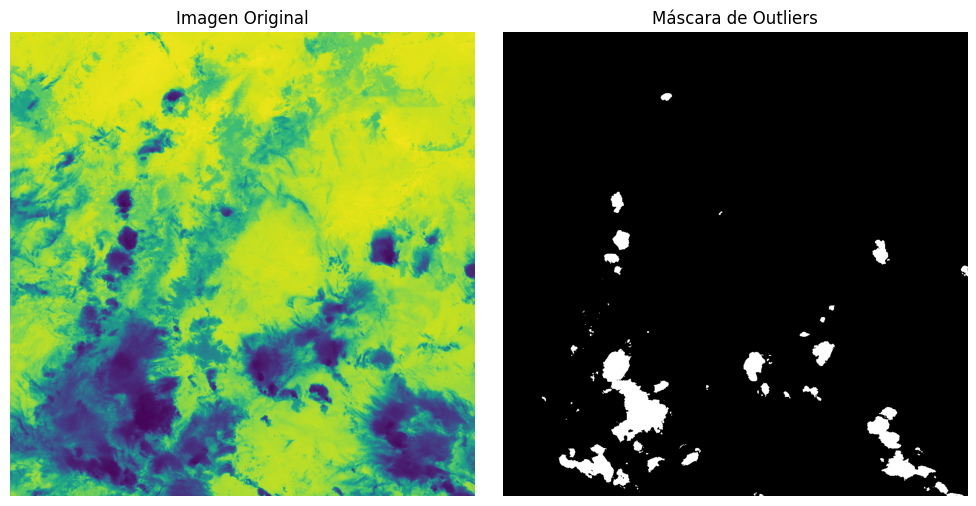

In [15]:
import matplotlib.pyplot as plt
imagen = df_imagenes.loc[1206, 'radiancia']
mask = df_imagenes.loc[1206, 'outliers_mask']

plt.figure(figsize=(10, 5))

# Imagen original
plt.subplot(1, 2, 1)
plt.imshow(imagen, cmap='viridis')
plt.title('Imagen Original')
plt.axis('off')

# Outliers (máscara)
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Máscara de Outliers')
plt.axis('off')

plt.tight_layout()
plt.show()

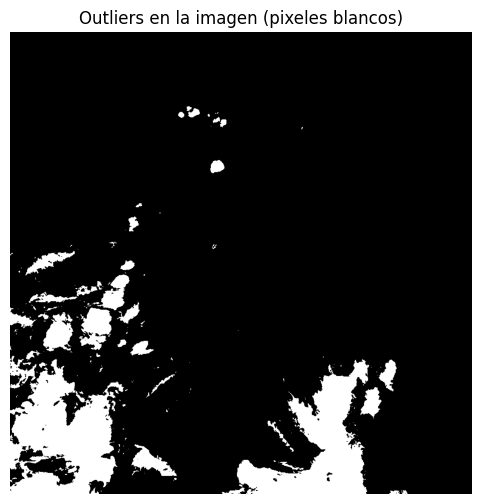

In [ ]:
import matplotlib.pyplot as plt

# Suponiendo que ya tienes una fila con la matriz 'outliers_mask'
# Por ejemplo, graficamos la de la primera fila:
outlier_mask = df_imagenes.loc[1206, 'outliers_mask']

plt.figure(figsize=(6, 6))
plt.imshow(outlier_mask, cmap='gray')  # 'gray' muestra True como blanco, False como negro
plt.title('Outliers en la imagen (pixeles blancos)')
plt.axis('off')
plt.show()

In [8]:
df_imagenes.head(10)

,fecha,mes,hora,radiancia,num_outliers,outliers_mask
1206,2024-01-01,1,00:00,"[[97.861824, 97.67891, 97.22162, 97.084435, 97...",30103,"[[False, False, False, False, False, False, Fa..."
6522,2024-01-01,1,01:00,"[[94.24924, 98.776405, 99.27942, 99.23369, 99....",16313,"[[False, False, False, False, False, False, Fa..."
2186,2024-01-01,1,02:00,"[[98.684944, 98.82213, 98.684944, 98.86786, 98...",5149,"[[False, False, False, False, False, False, Fa..."
1773,2024-01-01,1,03:00,"[[97.99901, 98.41057, 98.684944, 98.776405, 98...",2803,"[[False, False, False, False, False, False, Fa..."
5567,2024-01-01,1,04:00,"[[99.096504, 98.95932, 98.684944, 98.59348, 98...",4694,"[[False, False, False, False, False, False, Fa..."
6685,2024-01-01,1,05:00,"[[98.273384, 97.99901, 98.684944, 99.32515, 99...",6767,"[[False, False, False, False, False, False, Fa..."
3616,2024-01-01,1,06:00,"[[94.20351, 95.026634, 94.75226, 93.47185, 92....",14484,"[[False, False, False, False, False, False, Fa..."
2037,2024-01-01,1,07:00,"[[91.322586, 93.2432, 93.19747, 93.10602, 93.8...",22502,"[[False, False, False, False, False, False, Fa..."
2842,2024-01-01,1,08:00,"[[98.54776, 97.95328, 95.438194, 97.26735, 98....",27249,"[[False, False, False, False, False, False, Fa..."
1905,2024-01-01,1,09:00,"[[86.24668, 88.075836, 92.64873, 96.53568, 96....",31528,"[[False, False, False, False, False, False, Fa..."


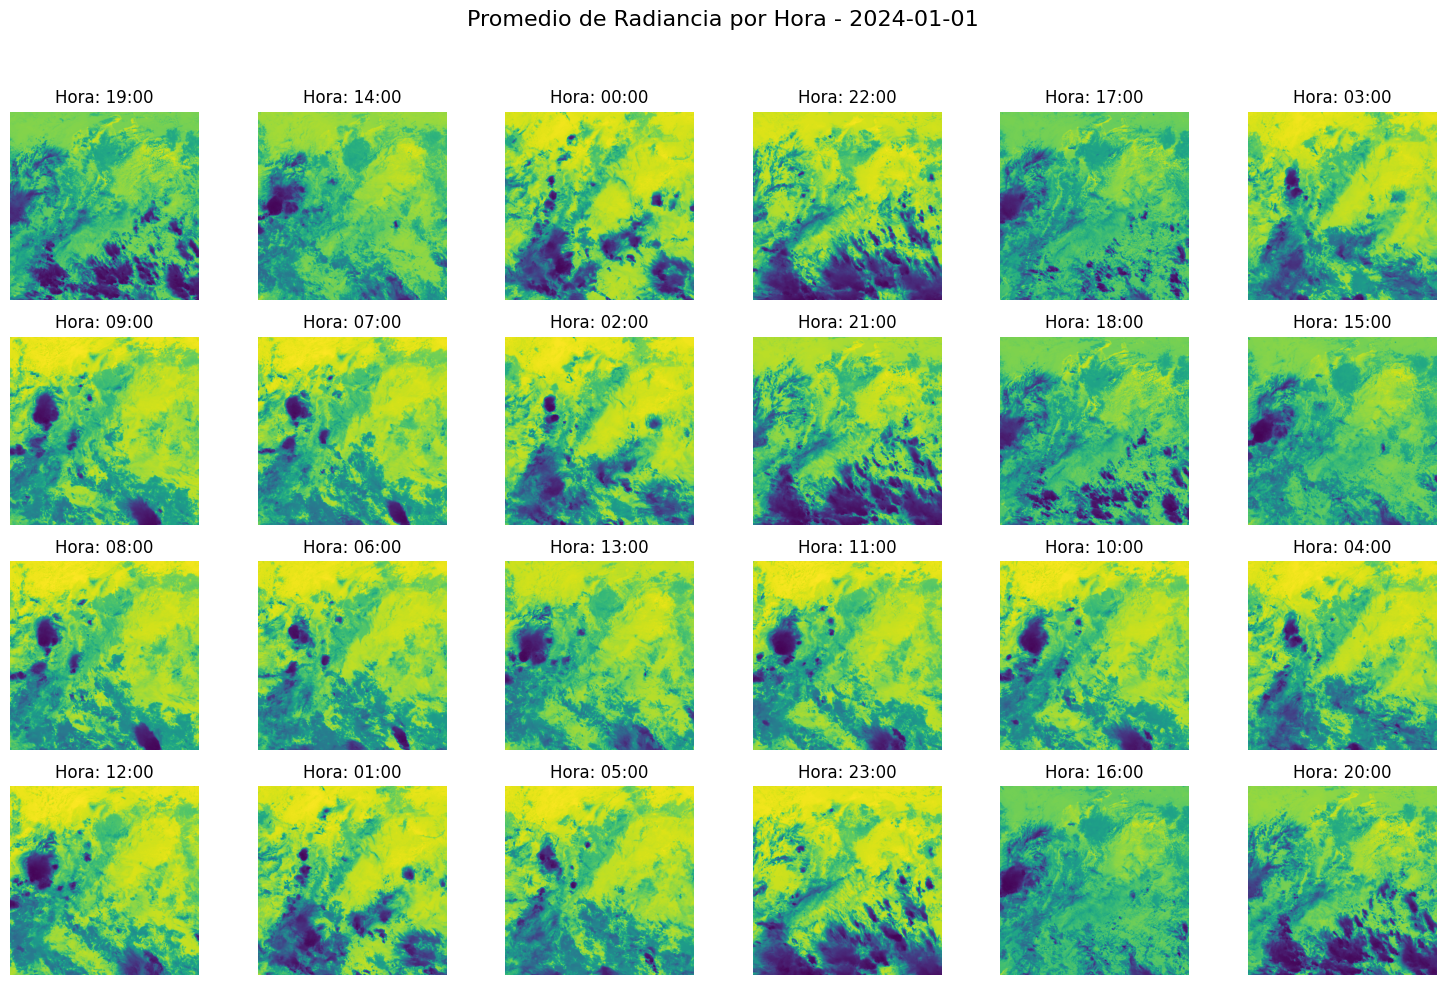

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Filtrar los datos para el día 2024-01-01
fecha_filtrada = pd.Timestamp("2024-01-01")
df_dia = df_imagenes[df_imagenes["fecha"] == fecha_filtrada]

# Calcular el promedio de radiancia para cada hora del día
promedios_hora = df_dia["radiancia"].apply(np.mean).values

# Crear subplots individuales para cada hora
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 10))  # 24 horas en una cuadrícula de 4x6
axes = axes.flatten()  # Aplanar los ejes para iterar fácilmente

for i, ax in enumerate(axes):
    if i < len(promedios_hora):
        ax.imshow(df_dia.iloc[i]["radiancia"], cmap="viridis")
        ax.set_title(f'Hora: {df_dia.iloc[i]["hora"]}')
        ax.axis("off")  # Ocultar los ejes
    else:
        ax.axis("off")  # Ocultar los ejes vacíos

# Ajustar el diseño
plt.suptitle("Promedio de Radiancia por Hora - 2024-01-01", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

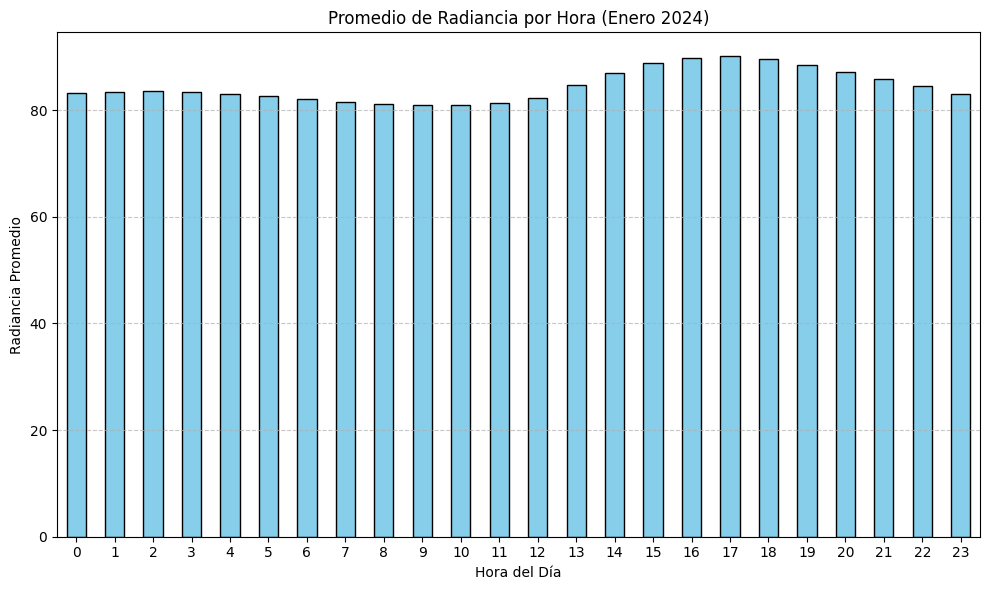

In [22]:
# Calcular el promedio de radiancia por hora para enero
promedio_por_hora_enero = df_enero.groupby(df_enero['fecha'].dt.hour)['radiancia_promedio'].mean()

# Graficar el promedio de radiancia por hora para enero
plt.figure(figsize=(10, 6))
promedio_por_hora_enero.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Promedio de Radiancia por Hora (Enero 2024)")
plt.xlabel("Hora del Día")
plt.ylabel("Radiancia Promedio")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

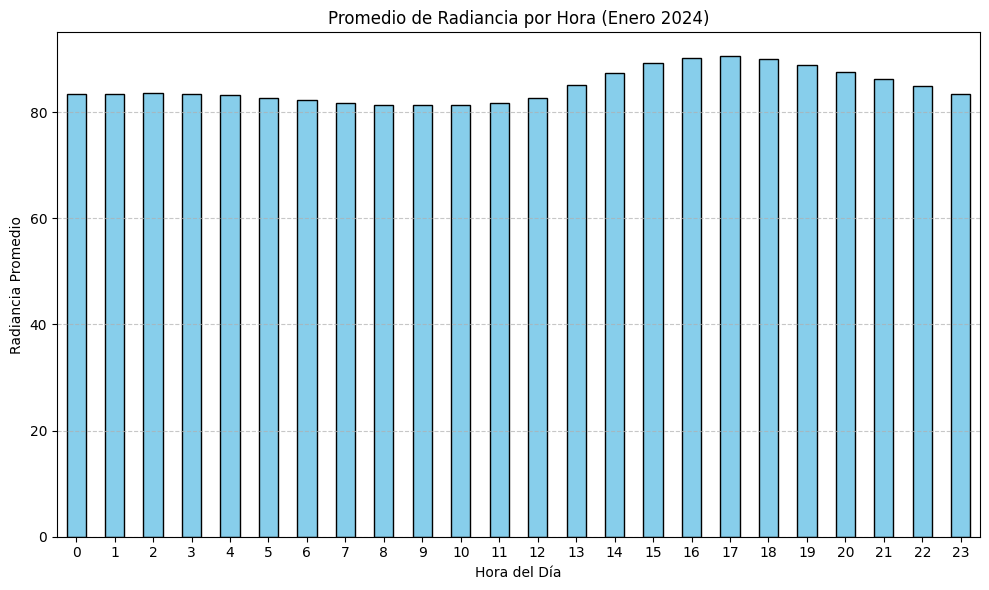

In [21]:
# Filtrar las fechas entre 2024-01-01 y 2024-01-30
fecha_inicio = pd.Timestamp('2024-01-01')
fecha_fin = pd.Timestamp('2024-01-30')
df_filtrado = df_imagenes[(df_imagenes['fecha'] >= fecha_inicio) & (df_imagenes['fecha'] <= fecha_fin)]

# Calcular el promedio de radiancia por hora
promedio_por_hora = df_filtrado.groupby(df_filtrado['fecha'].dt.hour)['radiancia_promedio'].mean()

# Graficar el promedio de radiancia por hora
plt.figure(figsize=(10, 6))
promedio_por_hora.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Promedio de Radiancia por Hora (Enero 2024)")
plt.xlabel("Hora del Día")
plt.ylabel("Radiancia Promedio")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Filtrar las fechas entre 2024-01-01 y 2024-02-28
fecha_inicio = pd.Timestamp('2024-01-01')
fecha_fin = pd.Timestamp('2024-02-28')
df_filtrado = df_imagenes[(df_imagenes['fecha'] >= fecha_inicio) & (df_imagenes['fecha'] <= fecha_fin)]

# Calcular el promedio de radiancia por hora
promedio_por_hora = df_filtrado.groupby(df_filtrado['fecha'].dt.hour)['radiancia_promedio'].mean()

# Graficar el promedio de radiancia por hora
plt.figure(figsize=(10, 6))
promedio_por_hora.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Promedio de Radiancia por Hora (Enero-Febrero 2024)")
plt.xlabel("Hora del Día")
plt.ylabel("Radiancia Promedio")
plt.xticks(rotation=0)
plt.grid(axis='# Graficar el promedio de radiancia por hora
plt.figure(figsize=(10, 6))
promedio_por_hora.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Promedio de Radiancia por Hora (Enero-Febrero 2024)")
plt.xlabel("Hora del Día")
plt.ylabel("Radiancia Promedio")
plt.xticks(rotation=0)
plt.grid(axis='

# Mostrar los resultados
print(promedio_por_hora)

fecha
0     80.210907
1     80.303154
2     80.439186
3     80.401031
4     80.218964
5     79.810822
6     79.353584
7     78.953568
8     78.827507
9     78.868576
10    79.110207
11    79.440094
12    80.524757
13    82.774559
14    84.945129
15    87.114090
16    87.805435
17    88.029686
18    87.471123
19    86.242561
20    84.770370
21    83.177963
22    81.806023
23    80.372475
Name: radiancia_promedio, dtype: float32


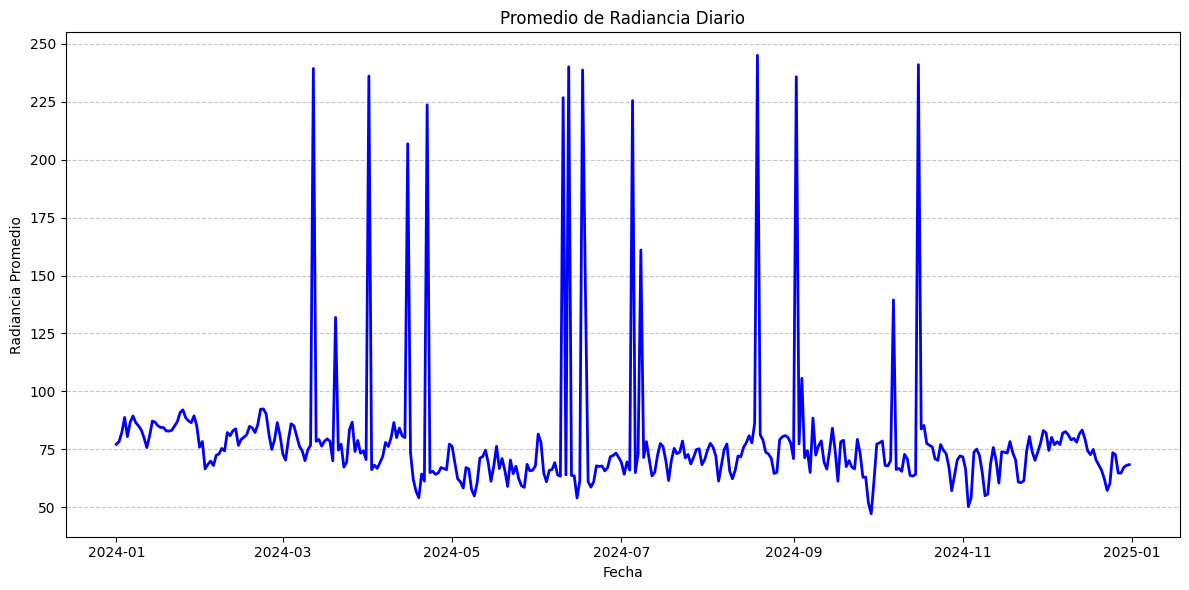

In [16]:
# Agregar una columna con solo la fecha (sin hora)
df_imagenes['fecha_sin_hora'] = df_imagenes['fecha'].dt.date

# Calcular el promedio de radiancia por día
promedio_diario = df_imagenes.groupby('fecha_sin_hora')['radiancia_promedio'].mean()

# Graficar el promedio diario
plt.figure(figsize=(12, 6))
promedio_diario.plot(color='blue', linewidth=2)
plt.title("Promedio de Radiancia Diario")
plt.xlabel("Fecha")
plt.ylabel("Radiancia Promedio")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [15]:
# Fechas procesadas
fechas_procesadas = set(df_imagenes['fecha'])

# Fechas faltantes
fechas_faltantes = set(rango_fechas) - fechas_procesadas

# Mostrar resultados
print(f"Total de fechas procesadas: {len(fechas_procesadas)}")
print(f"Total de fechas faltantes: {len(fechas_faltantes)}")

Total de fechas procesadas: 8744
Total de fechas faltantes: 61


In [ ]:
# Calcular el promedio de radiancia por día
promedio_diario = df_imagenes.groupby('fecha_sin_hora')['radiancia_promedio'].mean()

# Graficar el promedio diario
plt.figure(figsize=(12, 6))
promedio_diario.plot(color='blue', linewidth=2)
plt.axhline(media_global, color='red', linestyle='--', linewidth=2, label=f"Media Global = {media_global:.2f}")
plt.title("Promedio de Radiancia Diario")
plt.xlabel("Fecha")
plt.ylabel("Radiancia Promedio")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Agregar una columna con solo la fecha (sin hora)
df_imagenes['fecha_sin_hora'] = df_imagenes['fecha'].dt.date

# Calcular el promedio de radiancia por día
promedio_diario = df_imagenes.groupby('fecha_sin_hora')['radiancia_promedio'].mean()

# Mostrar los primeros resultados
print(promedio_diario.head())

fecha_sin_hora
2024-01-01    77.209206
2024-01-02    78.325569
2024-01-03    82.345497
2024-01-04    88.789871
2024-01-05    80.505081
Name: radiancia_promedio, dtype: float32


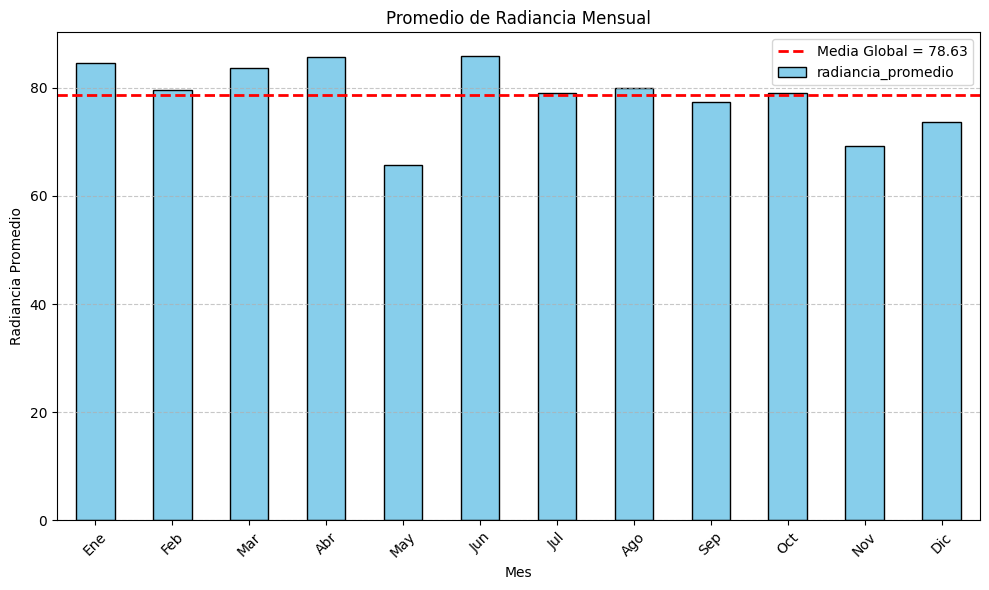

In [12]:
# Calcular el promedio de radiancia por mes
df_imagenes['mes'] = df_imagenes['fecha'].dt.month
promedio_mensual = df_imagenes.groupby('mes')['radiancia_promedio'].mean()

# Graficar el promedio mensual
plt.figure(figsize=(10, 6))
promedio_mensual.plot(kind='bar', color='skyblue', edgecolor='black')
plt.axhline(media_global, color='red', linestyle='--', linewidth=2, label=f"Media Global = {media_global:.2f}")
plt.title("Promedio de Radiancia Mensual")
plt.xlabel("Mes")
plt.ylabel("Radiancia Promedio")
plt.xticks(ticks=range(12), labels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [6]:
# Identificar archivos que no se procesaron correctamente
archivos_totales = os.listdir(ruta_archivos)

# Extraer los nombres de los archivos procesados directamente
archivos_procesados = [os.path.basename(archivo) for archivo in archivos_totales if procesar_archivo(archivo) is not None]

# Calcular los archivos faltantes
archivos_faltantes = set(archivos_totales) - set(archivos_procesados)

# Mostrar información
print(f"Total de archivos en la carpeta: {len(archivos_totales)}")
print(f"Total de archivos procesados: {len(archivos_procesados)}")
print(f"Total de archivos faltantes: {len(archivos_faltantes)}")

# Mostrar los archivos faltantes
if archivos_faltantes:
    print("Archivos faltantes:")
    for archivo in archivos_faltantes:
        print(archivo)
else:
    print("No hay archivos faltantes.")

KeyboardInterrupt: 

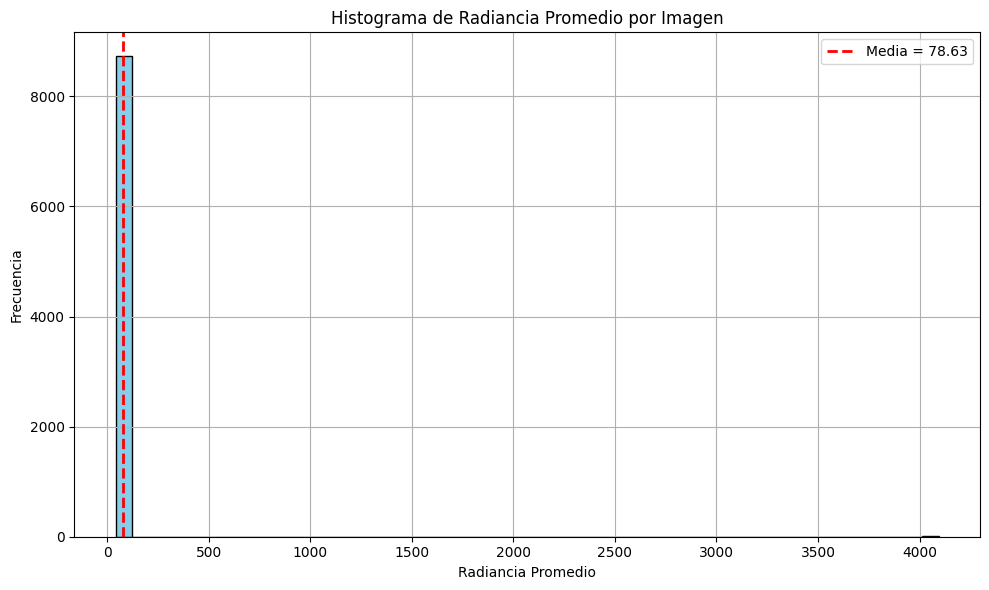

In [10]:
# Calcular el promedio de radiancia para cada imagen
df_imagenes["radiancia_promedio"] = df_imagenes["radiancia"].apply(np.mean)

# Verificar número de registros
assert len(df_imagenes) == 8744, "La cantidad de registros no es 6002."

# Calcular la media global de los promedios de radiancia
media_global = df_imagenes["radiancia_promedio"].mean()

# Graficar el histograma
plt.figure(figsize=(10, 6))
plt.hist(df_imagenes["radiancia_promedio"], bins=50, color='skyblue', edgecolor='black')
plt.axvline(media_global, color='red', linestyle='--', linewidth=2, label=f"Media = {media_global:.2f}")
plt.title("Histograma de Radiancia Promedio por Imagen")
plt.xlabel("Radiancia Promedio")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
df_imagenes['fecha'] = pd.to_datetime(df_imagenes['fecha'])

In [6]:
df_imagenes

,fecha,hora,radiancia
0,2024-01-01 02:00:00,02:00,"[[98.684944, 98.82213, 98.684944, 98.86786, 98..."
1,2024-01-01 00:00:00,00:00,"[[97.861824, 97.67891, 97.22162, 97.084435, 97..."
2,2024-01-01 03:00:00,03:00,"[[97.99901, 98.41057, 98.684944, 98.776405, 98..."
3,2024-01-01 01:00:00,01:00,"[[94.24924, 98.776405, 99.27942, 99.23369, 99...."
4,2024-01-01 04:00:00,04:00,"[[99.096504, 98.95932, 98.684944, 98.59348, 98..."
5,2024-01-01 05:00:00,05:00,"[[98.273384, 97.99901, 98.684944, 99.32515, 99..."
